In [1]:
%matplotlib inline
import numpy as np
from numpy import array
np.set_printoptions(threshold=1000)

from math import ceil

from matplotlib import pylab as plt
from matplotlib.pyplot import imshow

from pylab import imread

import skimage
from skimage import morphology, measure, draw, feature, exposure
from skimage.color import rgb2hsv, rgb2gray
from skimage.morphology import square
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import watershed

import cv2

from scipy import ndimage as ndi

In [2]:
def show_array(arr, cols=3):
    "Show a mosaic of images list and save it to jpg"
    cols = int(np.sqrt(len(arr)))
    rows = ceil(len(arr)/cols)
    plt.figure(figsize=(cols*30,rows*20))
    
    for i,img in enumerate(arr):
        ax = plt.subplot(rows, cols, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        imshow(img, cmap='gray')
    plt.savefig("tramwaje", dpi=100)

def show(*args):
    """Show multiple images in a row"""
    plt.figure(figsize=(20,12))
    for i,img in enumerate(args):
        plt.subplot(1, len(args), i+1)
        imshow(img, cmap='gray')

In [3]:
def discard_small_and_big(segmentated_img):
    #discard small object - noise and big - tram or buildings
    label_objects, nb_labels = ndi.label(segmentated_img)
    
    sizes = np.bincount(label_objects.ravel())  #ilość wystąpień każdej cyfry w sprasowanej tabeli
    
#     print("sizes", sizes, max(sizes), min(sizes))
#     n, bins, patches = plt.hist(sizes[np.logical_and(sizes<1000, sizes>50)])
#     print(n, bins)
    
    mask_sizes = np.logical_and(sizes<400, sizes>80) # dobrać wartości do eliminacji małych i dużych obiektów 
    cleaned = mask_sizes[label_objects]

    return cleaned

def segmentate_watershed(img):
    """Apply watershed segmentation to gray image"""
    """cf. [1],[2]"""
    elevation_map = sobel(img)

    markers = np.zeros_like(img)
    markers[img < 0.4] = 1
    markers[img > 0.95] = 2

    segmentation = watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)

    return segmentation

def mask_from_channel(x:int, treshold:int ):
    img_chann = img[:,:,x] 
    
    img_chann_bw = np.zeros_like(img_chann)
    img_chann_bw[img_chann > treshold] = 1
    
    return img_chann_bw


def origin_and_result(img, res):
    red_pic = np.empty_like(img)
    
    for r in range(len(red_pic)):
        for c in range(len(red_pic[0])):
            red_pic[r][c] = (255,0,0)
            
    red_pic = cv2.bitwise_and(red_pic, red_pic, mask = res)
    
    return cv2.add(img, red_pic)

def draw_circles(img):
    """ Detect circles in the image and draw them """
    """ cf. [6]"""
    
    output = img.copy()
    circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 1.2, 100) #maxRadius=100
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int") # (x, y) coordinates and radius to int
        for (x, y, r) in circles:
            # draw circle and center on the output image
            cv2.circle(output, (x, y), r, (0, 255, 0), 3)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1) # center
    
    return output

In [4]:
# tram_names = ["10_01", "10_02", "1_01", "1_02", "1_03", "1_04", "1_05", "1_06", "1_07", "11_01", "11_02", "11_03", "11_04", "11_05", "11_06", "12_01", "12_02", "12_03", "12_04", "12_05", "13_01", "13_02", "13_03", "14_01", "14_02", "14_03", "14_04", "14_05", "15_01", "15_02", "15_03", "16_01", "16_02", "16_03", "16_04", "16_05", "16_06", "16_07", "16_08", "16_09", "16_10", "16_11", "16_12", "16_13", "16_14", "16_15", "16_16", "16_17", "16_18", "16_19", "16_20", "16_21", "16_22", "17_01", "17_02", "17_03", "17_04", "17_05", "17_06", "18_01", "18_02", "19_01", "2_01", "21_01", "3_01", "3_02", "3_10", "4_01", "4_02", "4_03", "4_04", "5_01", "5_02", "5_03", "5_04", "5_05", "5_06", "5_07", "5_08", "5_09", "5_10", "5_11", "5_12", "5_13", "5_14", "6_01", "6_02", "6_03", "6_04", "6_05", "6_06", "6_07", "6_08", "7_01", "7_02", "8_01", "8_02", "9_01", "9_02", "9_03", "wiele_5_16_01", "X_01"]
tram_names = ["1_02", "1_06", "2_01" , "5_14", "4_04" ,"5_07","5_12","6_02", "12_02"]
# tram_names = ["4_04"]

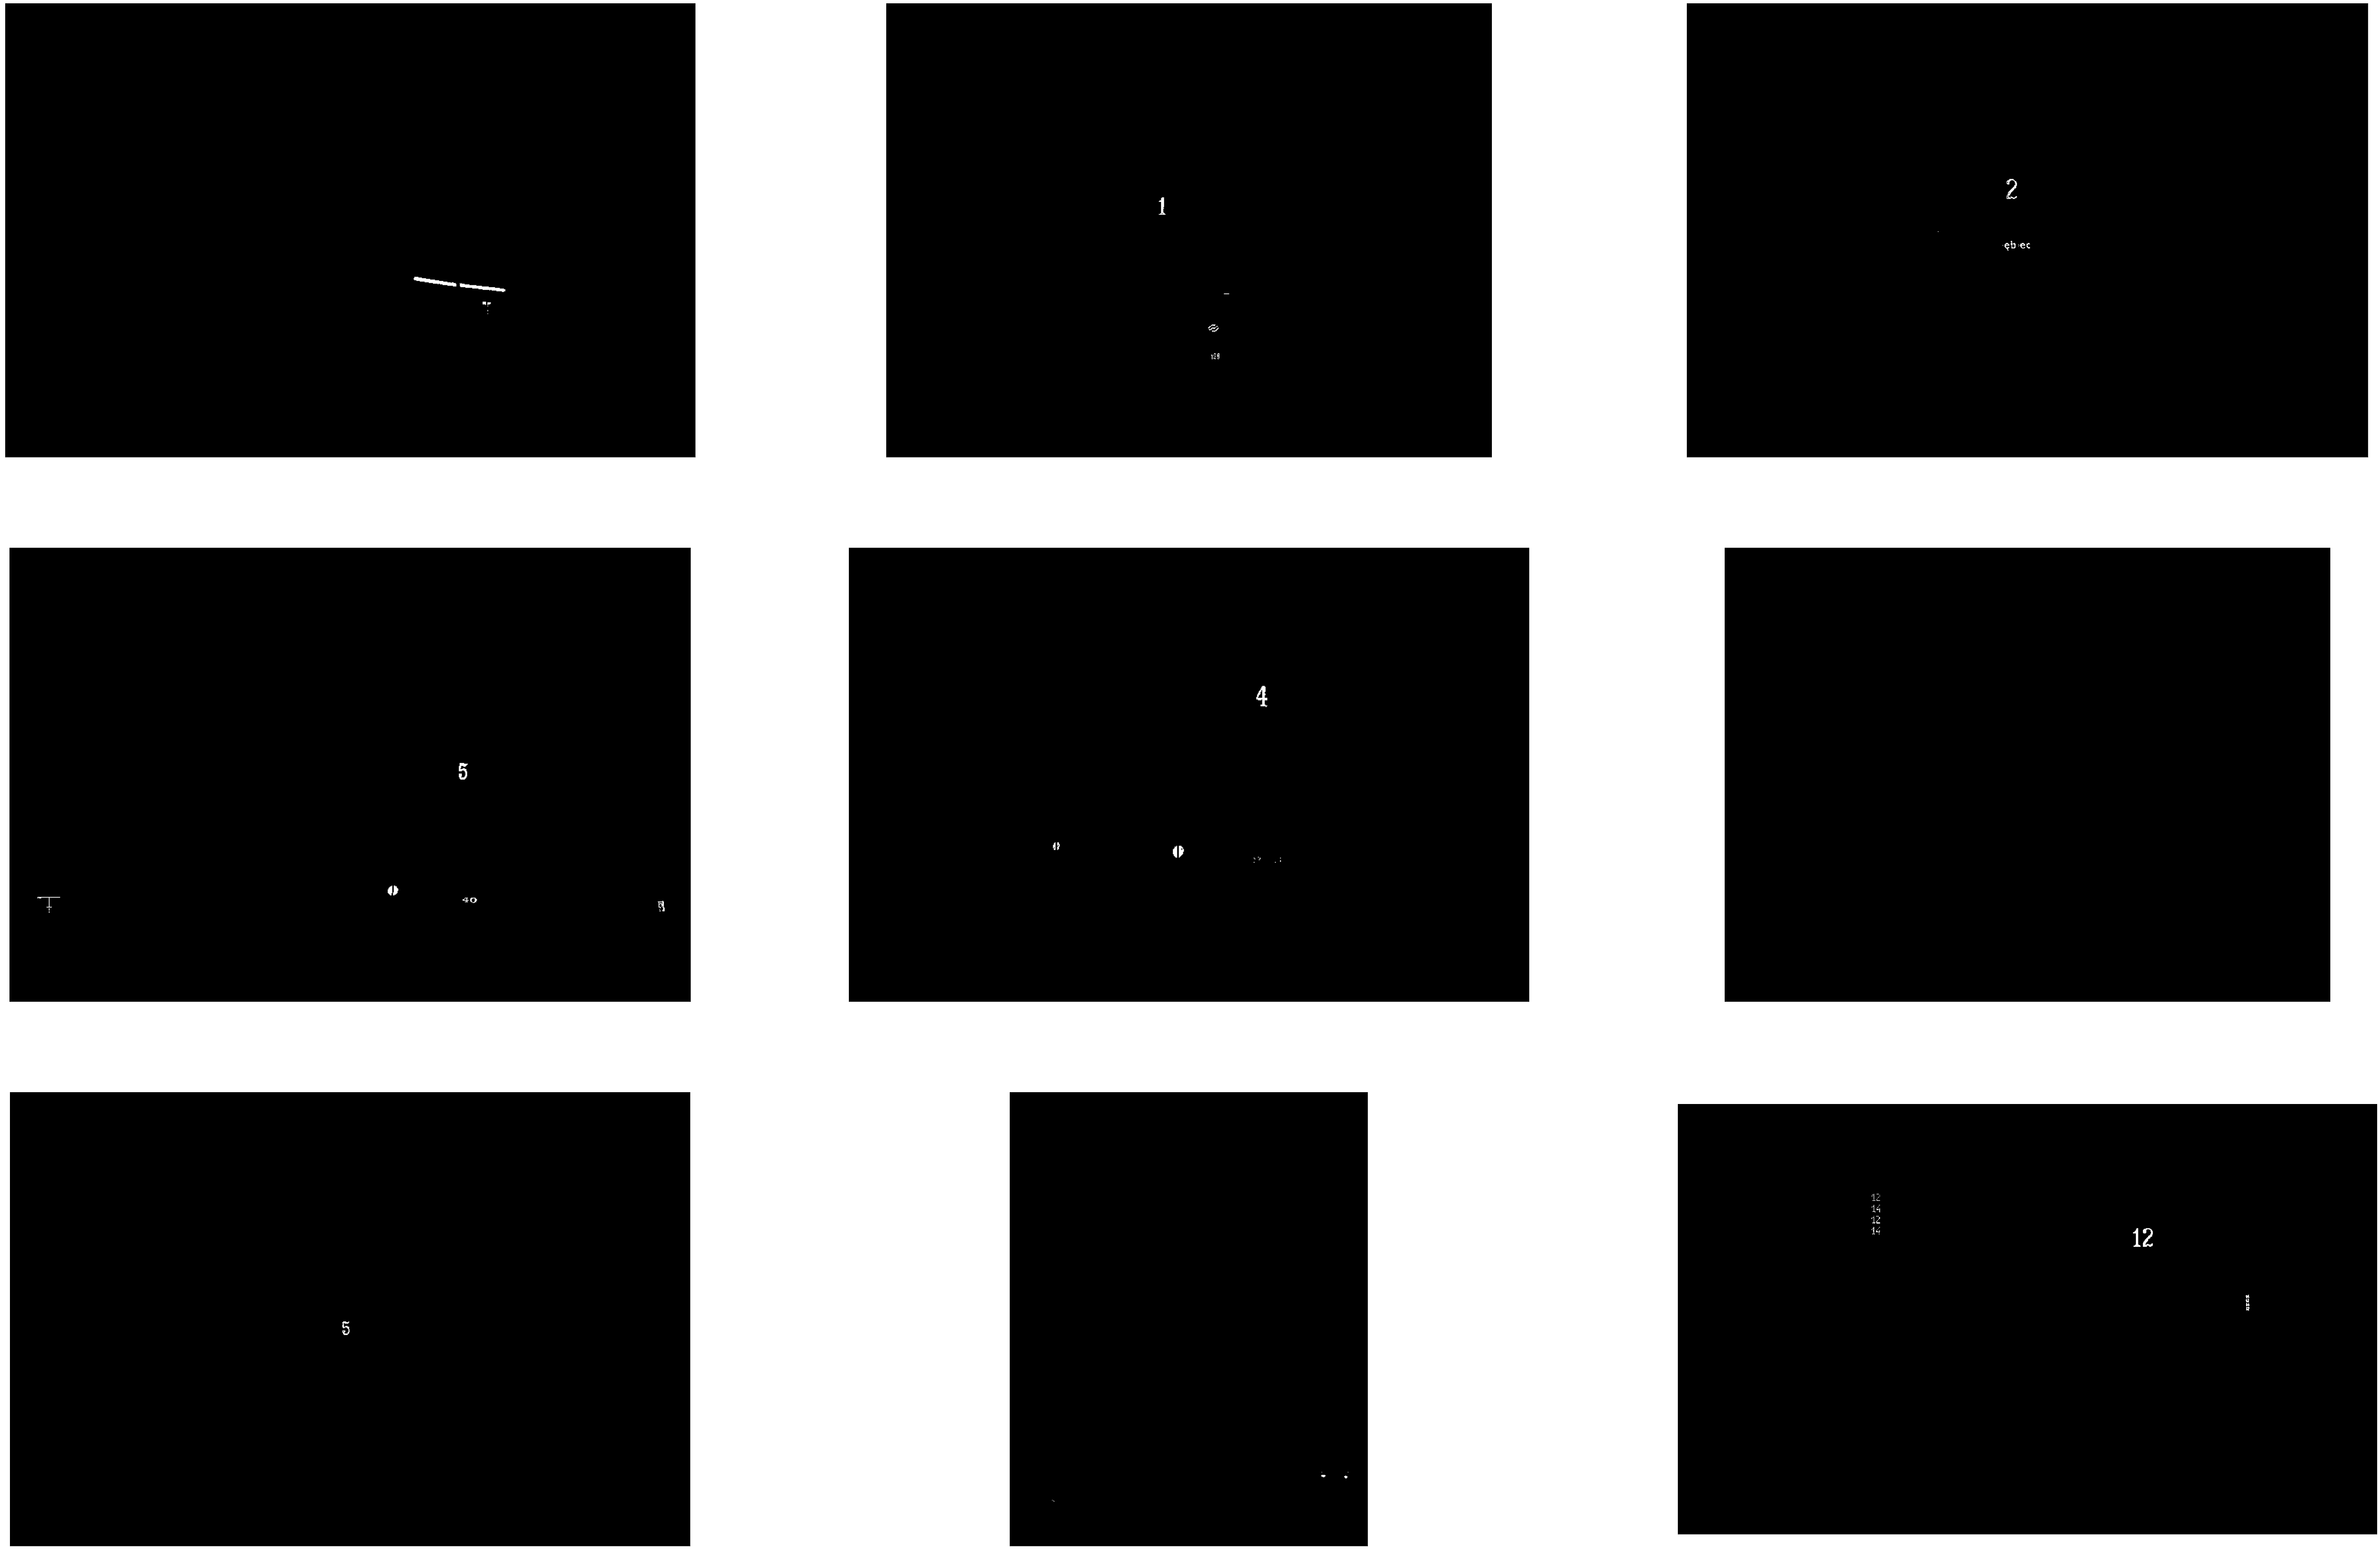

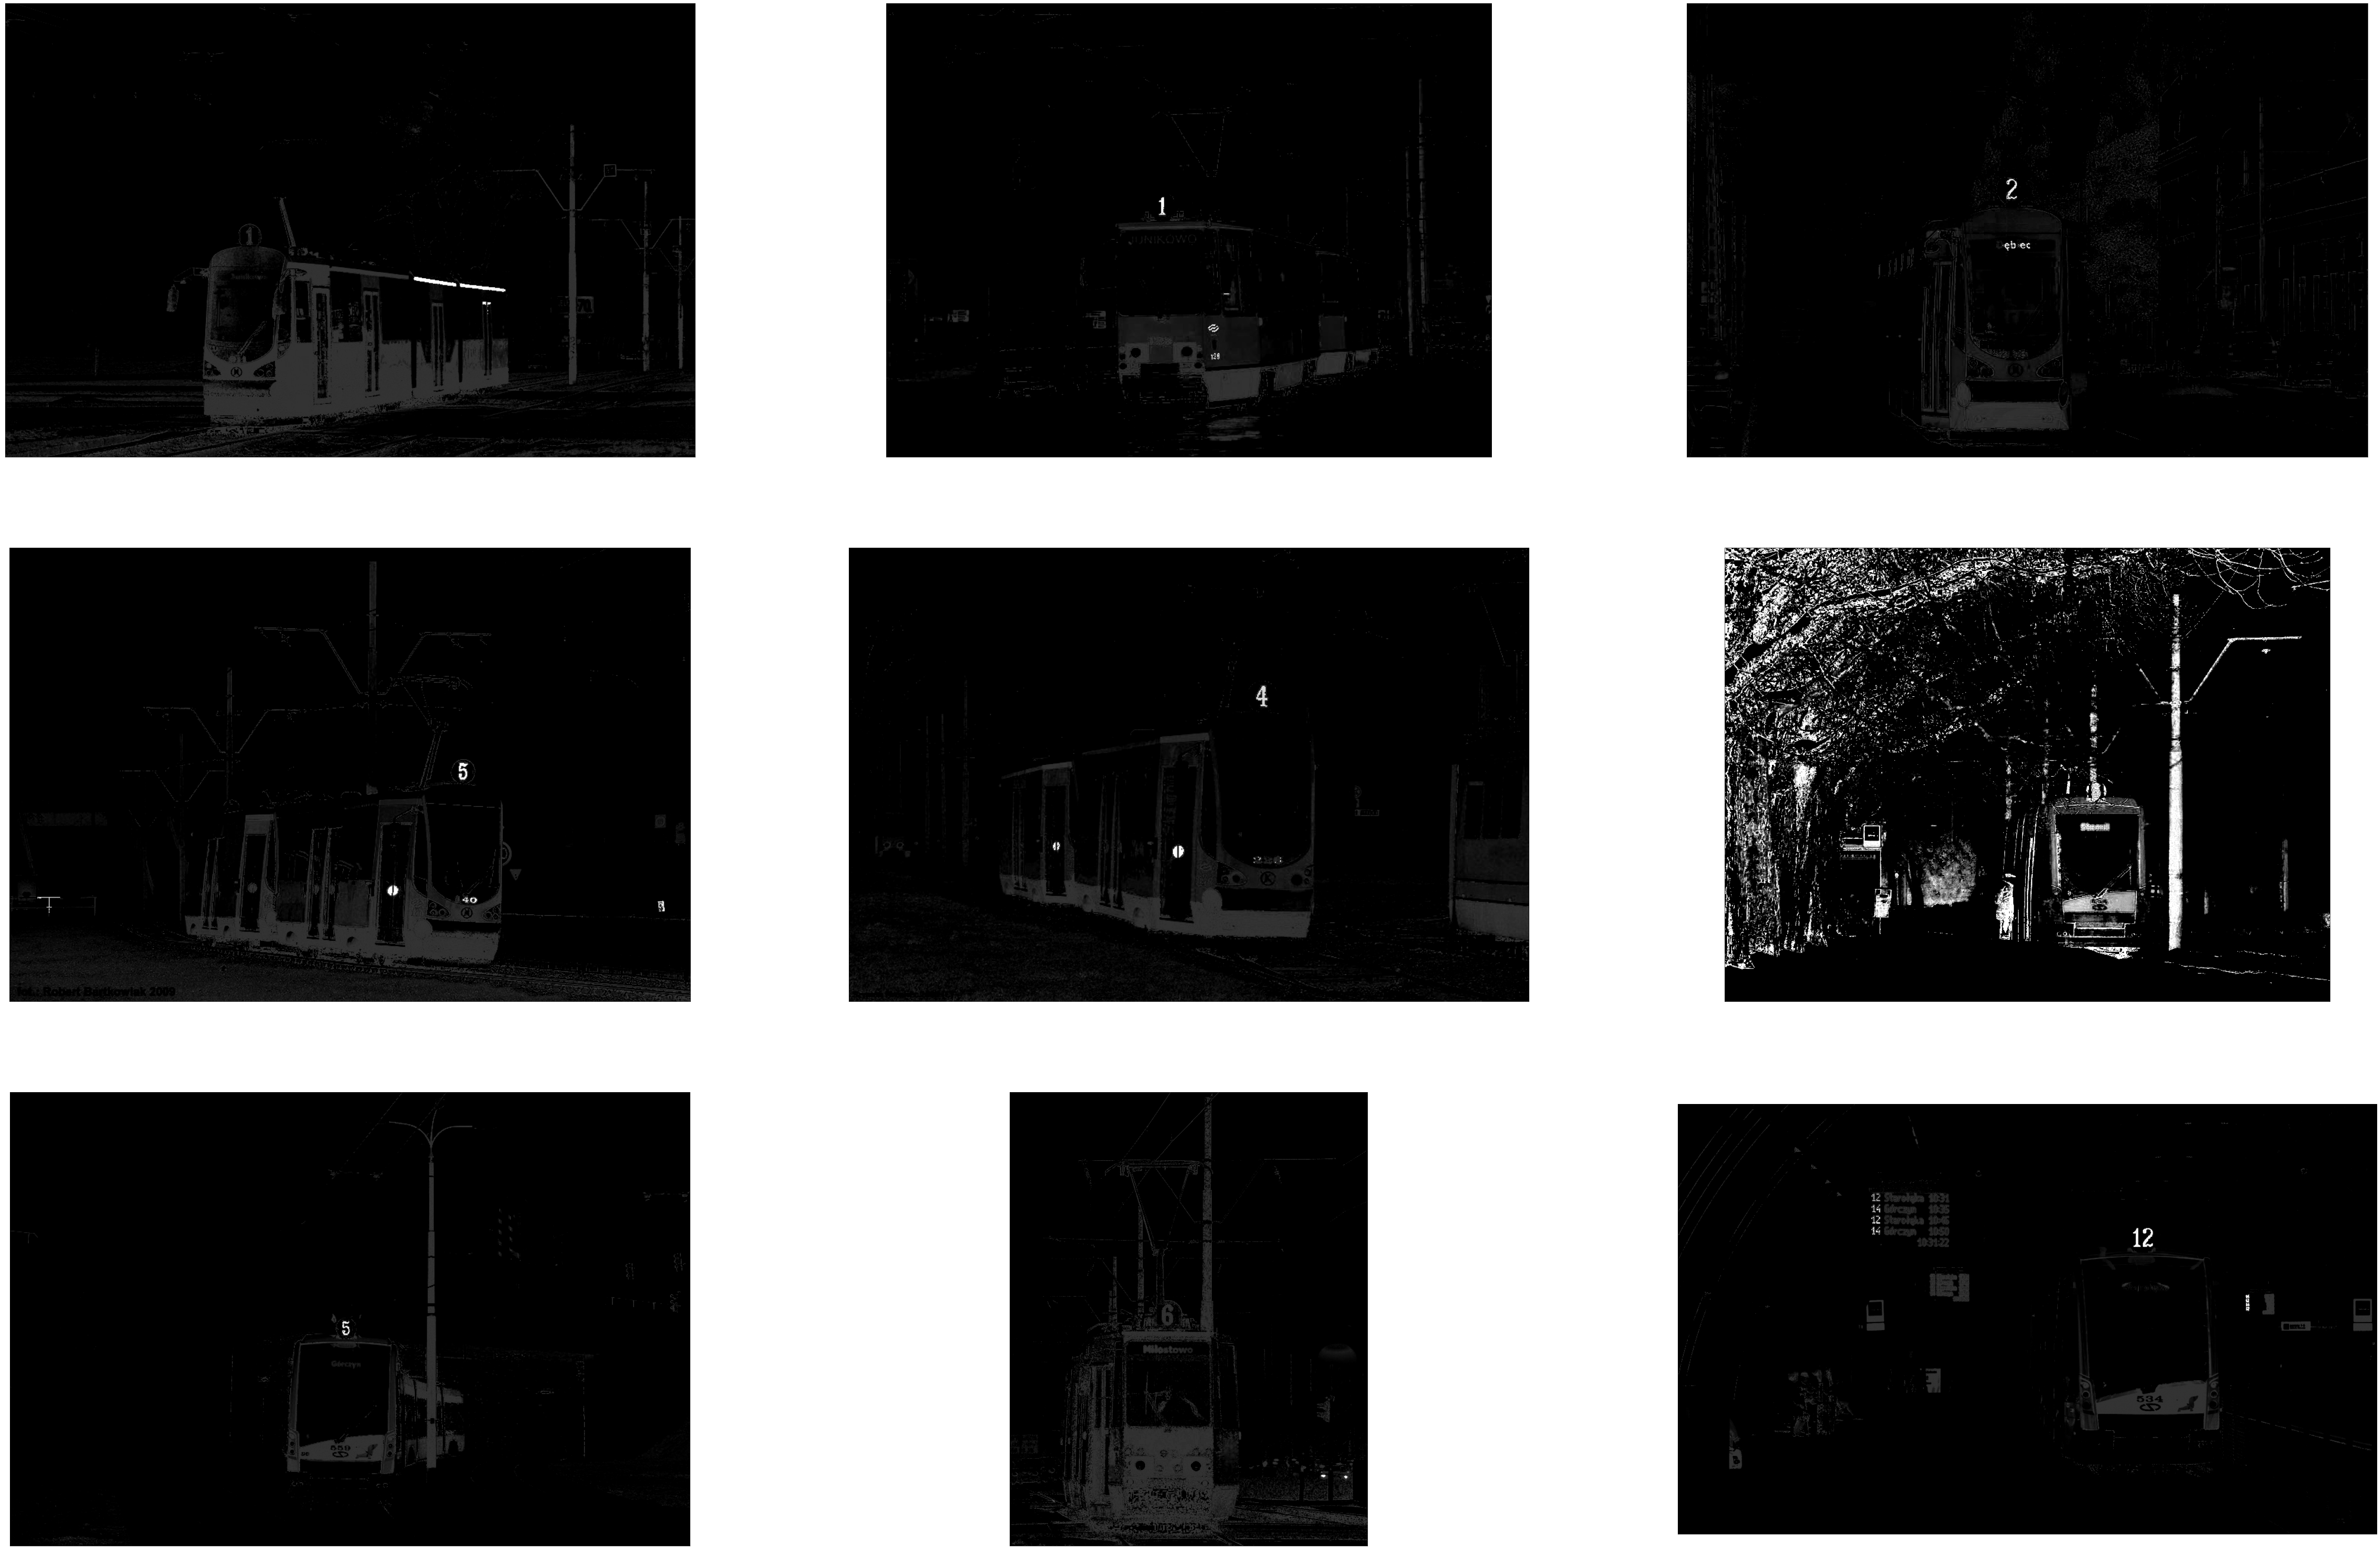

In [7]:
"""podejście I - segmentacja na podstawie nasycenia"""

imgs = []
imgs_obr = []
imgs_both = []

for tram in tram_names:
    img = imread("dane/"+tram+".jpg")
    imgs.append(img)
    img_sat = rgb2hsv(img)[:,:,1]
    
    # recognize segments and choose the best
    segmentated = segmentate_watershed(img_sat)
    cleaned = discard_small_and_big(segmentated)
    cleaned = cleaned.astype(np.uint8)  
    
    # eliminate not red
    red_mask = mask_from_channel(0, 210)    
    masked = cv2.bitwise_and(cleaned, cleaned, mask = red_mask)

    # eliminate white (or blue)
    blue_mask = mask_from_channel(2, 200)
    blue_mask = cv2.bitwise_not(blue_mask)
    masked = cv2.bitwise_and(masked, masked, mask = blue_mask)
        
    img_dark = ((img_sat-0.5)/2).clip(0,1)
    res = cv2.add(img_dark, masked.astype(np.float64))
    
    imgs_obr.append(masked)
    imgs_both.append(res) 
    
show_array(imgs_obr)
show_array(imgs_both)

In [ ]:
""" Podejście drugie - wykrywanie konturów - canny + findContours """
# czasem udaje mu się wykryć koła, ale jest za dużo śmieci, żeby to miało sens
imgs = []

for tram in tram_names:
    img = imread("dane/"+tram+".jpg")

    # preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7,7), 0)
    edged = cv2.Canny(blurred, 50, 200, 255)

    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(img, contours, -1, (0,255,0), 3)

    # choosing contours with the right area
    contour_list = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if (area <100 and area > 20):
            contour_list.append(contour)
    # może lepiej to wykrywać jakimś stosunkiem pola do obwodu albo czymś takim?
            
    cv2.drawContours(img, contour_list, -1, (255,0,0), 3)
    
    #dalej trzeba by rozpoznać koła np. cv2.approxPolyDP(), albo jakimś innym Houghem
    
    imgs.append(img)
show_array(imgs)

In [ ]:
"""Podejście trzecie - wykrywanie kół - HoughCircles"""
# wykrywa koła tam gdzie ich nie ma, ale nie tam gdzie są
# czy one powinny być zamalowane, albo czy robić to na jakkolwiek obrobionym zdjęciu?

img = imread("dane/"+tram_names[0]+".jpg")

img_circles = draw_circles(img)

show(img_circles)

In [ ]:
hist, hist_centers = exposure.histogram(img_sat)
plt.plot(hist_centers, hist)

# ideas:
1. **więcej preprocessingu** (jakieś podbijanie kontrastu, rozmycie, ustalenie jasności...)
1. operowanie jednak na skali szarości?
1. **łączenie rozpoznanych obiektów ze skali szarości i z nasycenia albo z nasycenia i wartości**
1. jakoś inaczej dobrać parametry przed canny?
    - Inne rozmycie? 
    - cv2.bilateralFilter(rawImage, 5, 175, 175) zamiast gaussian?
1. zmniejszenie rozdzielczości? (Czy to ma jakieś znaczenie)

1. wykryć koła, sprawdzić ich wielkość, wyciąć i tam szukać lizczb tym algorytmem, który mam
    - może być wiele kół, może nie wykryć poprawnie koła
    
1. Jak wykryć te koła?
    - HoughCircles
    - minEnclosingCircle
    
1. **Kanał czerwony**


Raczej nie:
1. wykryć największy obiekt (prawdopodobnie to będzie tramwaj) i szukać na górze od niego
    - największy może nie być tramwaj, może wykrywać tramwaj w częściach
1. ograniczyć szukanie tylko do górnej połowy zdjęcia, obciąć boki
    - jest ryzyko, że tam właśnie będzie numer, bo zdjęcie będzie słabe



- transformata hougha - raczej nieprzydatna
- momenty hu - do rozpoznawania koła?
- cv2.find_contorurs


# useful links

wykrywanie obiektów - segmentacja i canny   
[1] https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html?fbclid=IwAR3If7rhedSZYwVebDG6oBgy8pPsh6aFgEHUKh1wL7NhZ3XYrDwT4eUOBk4    
[2] https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_coins_segmentation.html?fbclid=IwAR0JfJK-Nh5Nb8W5rLdySQTCYm0uFPQPsd-AEq1TaExUX0kfpzrkVrk8MJA

wykrywanie liczb   
[3] LCD https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/

wycinanie tła   
[4] messi https://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html    
[5] z kamerki https://towardsdatascience.com/background-removal-with-python-b61671d1508a

HoughCircles   
[6] https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/